# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Data Collection and Wrangling](#wrangling)
    - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.


<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly.  

However, there is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. Run the first code cell below to load some packages and functions that will be used in the analysis. Then, complete the second code cell to print out the first trip recorded from each of the cities (the second line of each data file).


In [28]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
from pprint import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [29]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        
        trip_reader = csv.DictReader(f_in)
        
        
        
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)        
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
        
        pprint(first_trip)
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip



City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

You should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. When setting up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I will convert the Washington labels to match the other two.


In [30]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    Key: The csv module reads in all of the data as strings, including numeric
    values. I will need a function to convert the strings into an appropriate
    numeric type when making my transformations.
    see https://docs.python.org/3/library/functions.html
    """
    
    
    if city=='Washington': 
         duration = float(datum['Duration (ms)'])/(60*1000)
    else:
        duration=float(datum['tripduration'])/60
    return duration


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printe the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001
    

In [31]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    Key: I should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
   
    if city=='NYC':
        date_format=datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M:%S')
        
    elif city=='Chicago':
        date_format=datetime.strptime(datum['starttime'],'%m/%d/%Y %H:%M')
        
    else:
        date_format=datetime.strptime(datum['Start date'],'%m/%d/%Y %H:%M')
        
    month,hour,day_of_week=date_format.month,date_format.hour,date_format.strftime('%A')
            
    return (month, hour, day_of_week)


# Some tests to check that the code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I print the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]
    


In [32]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """
    
    if city=='Washington':
        if datum['Member Type'] == 'Registered':
            return 'Subscriber'
    else: 
        return datum['usertype']


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printe the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]



Now, use the helper functions I wrote above to create a condensed data file for each city consisting only of the data fields indicated above. In the `/examples/` folder, there is an example data file from the [Bay Area Bike Share](http://www.bayareabikeshare.com/open-data) before and after conversion. Make sure that the output is formatted to be consistent with the example file.

In [33]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point={}
            
            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            
            new_point['duration']=duration_in_mins(row, city)
            new_point['month'], new_point['hour'], new_point['day_of_week']=time_of_trip(row, city)
            new_point['user_type'] =type_of_user(row, city)
            

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            #print(new_point)
            trip_writer.writerow(new_point)
                            

In [34]:
# Run this cell to check the work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now we have the data collected and wrangled, we're thus ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also be introduced to the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

**Question:** Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

In [35]:
! pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["city","total trips ", "sub prop", "non-sub prop","avg length","portion > 30mins","users > avg"]

def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """

    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
    # compute total number of rides
    n_total = n_subscribers + n_customers
    
    # return tallies as a tuple
    return(n_subscribers/n_total,n_customers/n_total, n_total)
    

In [36]:
trip={}
sub={}
cus={}
data_file = ('./examples/BayArea-Y3-Summary.csv','./data/Chicago-2016-Summary.csv','\
./data/NYC-2016-Summary.csv','./data/Washington-2016-Summary.csv')

for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    sub[city],cus[city],trip[city]=number_of_trips(file)
    
print('{} has the highest number of trips'.format(max(trip,key=trip.get)))
print('{} has the highest proportion of trips made by subscribers'.format(max(sub,key=sub.get)))
print('{} has the highest proportion of trips made by customers'.format(max(cus,key=cus.get)))


NYC has the highest number of trips
BayArea has the highest proportion of trips made by subscribers
Chicago has the highest proportion of trips made by customers


**Question:** Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [37]:
## Key: The csv module reads in all of the data as strings, including  ##
## numeric values. We need a function to convert the strings      ##
## into an appropriate numeric type before aggregating data.          ## 

def average_and_proportion(filename):
    with open(filename, 'r') as f_in:
        reader = csv.DictReader(f_in)
        all_trip=[]
        exceed=0
        below=0
        for row in reader:
            single_trip=float(row['duration'])
            all_trip.append(single_trip)
            if single_trip>30:
                exceed+=1
            else:
                below+=1
    return  sum(all_trip)/len(all_trip),(exceed/(exceed+below))*100  

for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    print('The average trip length for {} is {:.2f}, and {:.2f}% of rides made in each city are longer \
    than 30 minutes'.format(city,average_and_proportion(file)[0],average_and_proportion(file)[1]))
    

The average trip length for BayArea is 14.04, and 3.52% of rides made in each city are longer     than 30 minutes
The average trip length for Chicago is 16.56, and 8.33% of rides made in each city are longer     than 30 minutes
The average trip length for NYC is 15.81, and 7.30% of rides made in each city are longer     than 30 minutes
The average trip length for Washington is 18.93, and 10.84% of rides made in each city are longer     than 30 minutes


**Question**: Dig deeper into the question of trip duration based on ridership. Within each city, which type of user takes longer rides on average: Subscribers or Customers?

In [38]:
def longer_type(filename):
    subscriber_type=[]
    customer_type=[]
    with open (filename,'r') as f_in:
        reader=csv.DictReader(f_in)
        for row in reader:
            if row['user_type']=='Subscriber':
                subscriber_type_single=float(row['duration'])
                subscriber_type.append(subscriber_type_single)
            else:
                customer_type_single=float(row['duration'])
                customer_type.append(customer_type_single)
            
    return sum(subscriber_type)/len(subscriber_type),sum(customer_type)/len(customer_type)


for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    subscriber,customer=longer_type(file)
    if subscriber>=customer:
        s='True'
        print('in {},the average duration of subscriber is {:.2f}, \
        logner than that of customer which is {:.2f}'.format(city,subscriber,customer))
    else:
        s='False'
        print('in {},the average duration of subscriber is {:.2f}, \
        shorter than that of customer which is {:.2f}'.format(city,subscriber,customer))
    
    x.add_row([city,round(trip[city],2),round(sub[city],2),round(cus[city],2),\
               round(average_and_proportion(file)[0],2),round(average_and_proportion(file)[1],2),s])
            
print(x)


in BayArea,the average duration of subscriber is 9.51,         shorter than that of customer which is 54.55
in Chicago,the average duration of subscriber is 12.07,         shorter than that of customer which is 30.98
in NYC,the average duration of subscriber is 13.68,         shorter than that of customer which is 32.78
in Washington,the average duration of subscriber is 12.53,         shorter than that of customer which is 41.68
+------------+--------------+----------+--------------+------------+------------------+-------------+
|    city    | total trips  | sub prop | non-sub prop | avg length | portion > 30mins | users > avg |
+------------+--------------+----------+--------------+------------+------------------+-------------+
|  BayArea   |     6299     |   0.9    |     0.1      |   14.04    |       3.52       |    False    |
|  Chicago   |    72131     |   0.76   |     0.24     |   16.56    |       8.33       |    False    |
|    NYC     |    276798    |   0.89   |     0.11     | 

<a id='visualizations'></a>
### Visualizations

It will be interesting for us to look at how the trip times are distributed, so we use the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers as well as the Customers in selected city. Add limits to the plots to remove outliers so that the visualization will look better. As a bonus, set the plots up so that bars are in five-minute wide intervals. 


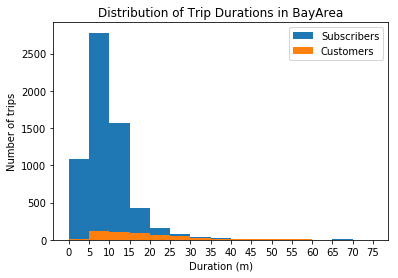

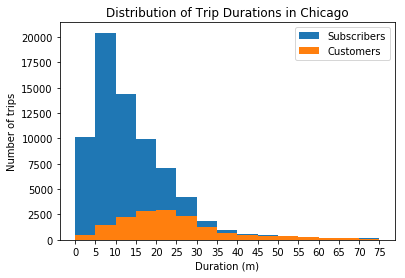

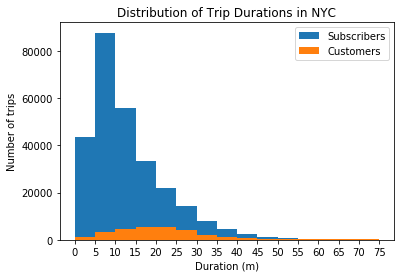

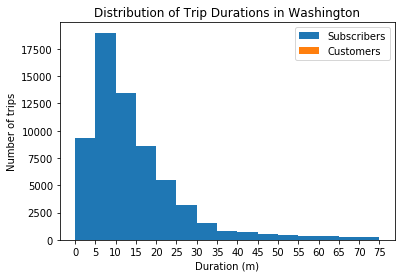

In [39]:
# load library
import matplotlib.pyplot as plt

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook.
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline 

def trip_times(filename):
    time_list=[]
    times_customers_list=[]
    with open (filename,'r') as f_in:
        reader=csv.DictReader(f_in)
        for row in reader:
            times=float(row['duration'])
            time_list.append(times)
            if row['user_type']=='Customer':
                times_customers=float(row['duration'])
                times_customers_list.append(times_customers)
    return time_list,times_customers_list
 
for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    all_trips,customers=trip_times(file)
    plt.hist(all_trips,bins=15,range=(0,75))
    plt.hist(customers,bins=15,range=(0,75))
    plt.xticks(range(0,80,5))
    plt.title('Distribution of Trip Durations in {}'.format(city))
    plt.xlabel('Duration (m)')
    plt.ylabel('Number of trips')
    plt.legend(['Subscribers','Customers'])
    plt.show()
    

BayArea:
- The duration distribution of both subscribers and customers in the BayArea is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 5-10;

Chicago:
- The duration distribution of subscribers in Chicago is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 5-10;
- The duration distribution of customer in Chicago is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 20-25. 

NYC:
- The duration distribution of subscribers in NYC is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 5-10;
- The duration distribution of customer in NYC is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 15-25.

Washington:
- The duration distribution of subscribers in Washington is positively skewed, it is asymmetric with a long tail on the right, with the mean value around 5-10.


#### How does ridership differ by month or season? Which month / season has the highest ridership? Does the ratio of Subscriber trips to Customer trips change depending on the month or season?


#### Is the pattern of ridership different on the weekends versus weekdays? On what days are Subscribers most likely to use the system? What about Customers? Does the average duration of rides change depending on the day of the week?


#### During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?


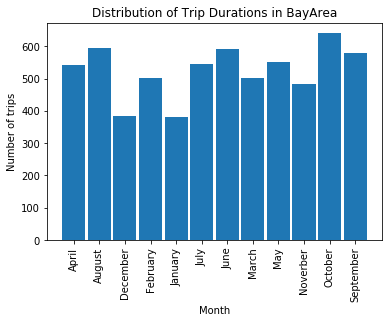

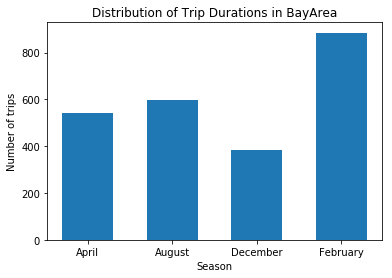

In BayArea, October/Summer has the highest ridership


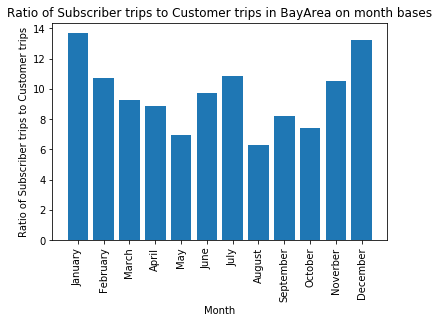

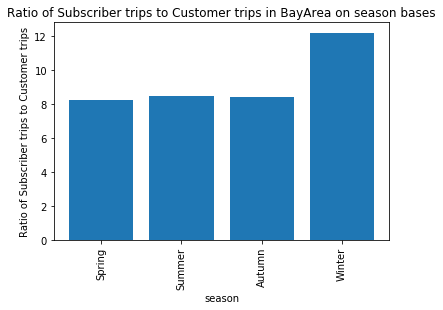

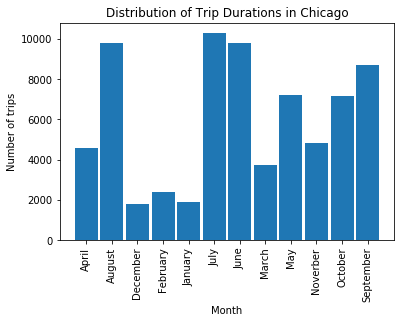

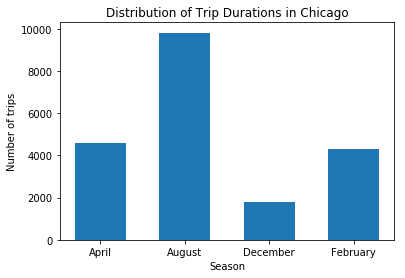

In Chicago, July/Summer has the highest ridership


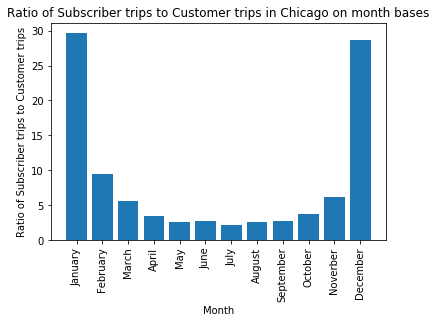

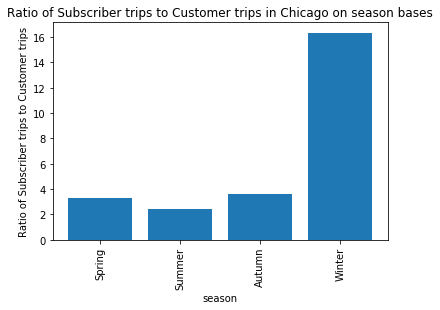

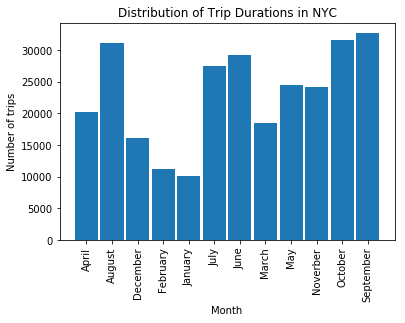

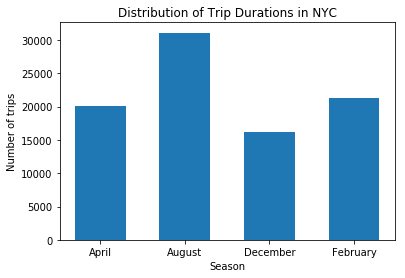

In NYC, September/Autumn has the highest ridership


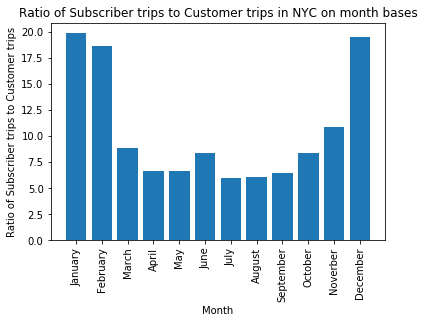

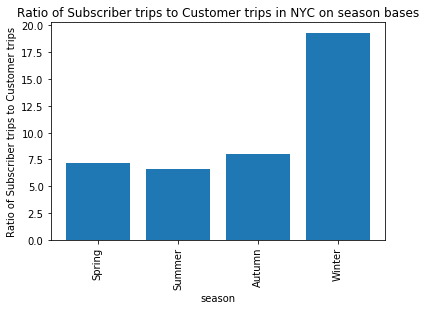

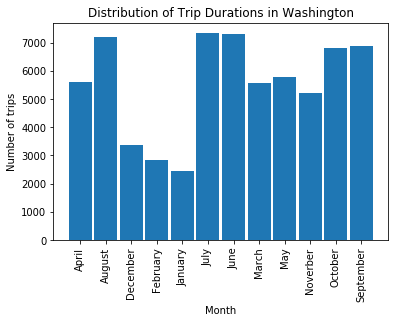

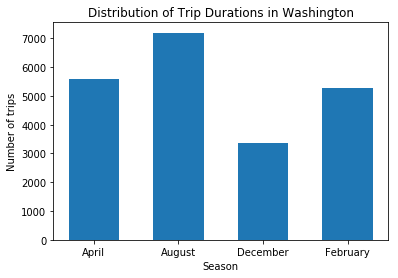

In Washington, July/Summer has the highest ridership


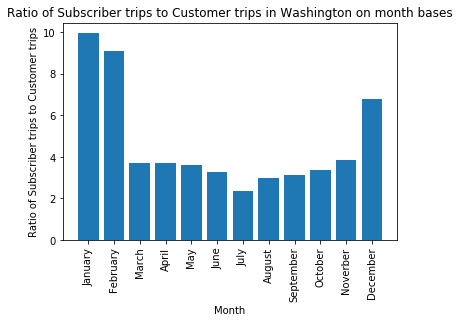

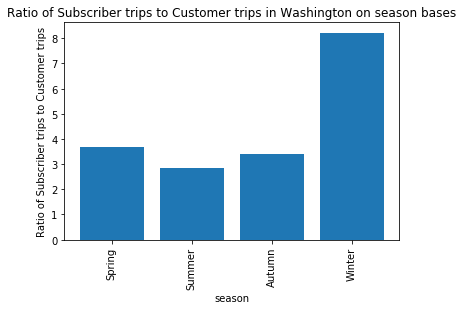

In [15]:
# how does ridership differ by month or season? 
# which month / season has the highest ridership? 
# does the ratio of Subscriber trips to Customer trips change depending on the month or season?

from statistics import mode

def explore(filename):
    mon_list=['January','February','March','April','May','June','July','August','September','October','Noverber','December']
    mon_trip=[]
    sea_trip=[]
    sub_mon={'January':0,'February':0,'March':0,'April':0,'May':0,'June':0,'July':0,'August':0,'September':0,'October':0,'Noverber':0,'December':0}
    sub_sea={'Spring':0,'Summer':0,'Autumn':0,'Winter':0}
    cus_mon={'January':0,'February':0,'March':0,'April':0,'May':0,'June':0,'July':0,'August':0,'September':0,'October':0,'Noverber':0,'December':0}
    cus_sea={'Spring':0,'Summer':0,'Autumn':0,'Winter':0}
    
    with open (filename,'r') as f_in:
        reader=csv.DictReader(f_in)
        
        for row in reader:
            mon_num=int(row['month'])
    
            mon=mon_list[mon_num-1]
        
            if mon in mon_list[2:5]:
                sea='Spring'
            elif mon in mon_list[5:8]:
                sea='Summer'
            elif mon in mon_list[8:11]:
                sea='Autumn'
            else:
                sea='Winter'
                
            mon_trip.append(mon)
            sea_trip.append(sea)
                           
            if row['user_type']=='Subscriber':
                sub_mon[mon]+=1
                sub_sea[sea]+=1
            else:
                cus_mon[mon]+=1
                cus_sea[sea]+=1
        
        ratio_mon=dict((k, float(sub_mon[k])/cus_mon[k]) for k in sub_mon)
        ratio_sea=dict((k, float(sub_sea[k])/cus_sea[k]) for k in sub_sea)

    return mon_trip,sea_trip,ratio_mon,ratio_sea,mode(mon_trip),mode(sea_trip)
        
for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    mon,sea,ratio_mon,ratio_sea,max_mon,max_sea=explore(file)
        
    plt.hist(mon,bins=12,range=(0,12),rwidth=0.9,align='left')
    plt.xticks(rotation='vertical')
    plt.title('Distribution of Trip Durations in {}'.format(city))
    plt.xlabel('Month')
    plt.ylabel('Number of trips')
    plt.show()

    plt.hist(mon,bins=4,range=(0,4),rwidth=0.6,align='left')
    plt.title('Distribution of Trip Durations in {}'.format(city))
    plt.xlabel('Season')
    plt.ylabel('Number of trips')
    plt.show()
    
    print('In {}, {}/{} has the highest ridership'.format(city,max_mon,max_sea))
    
    plt.bar(range(len(ratio_mon)), ratio_mon.values(), align='center')
    plt.xticks(range(len(ratio_mon)), ratio_mon.keys())
    plt.xticks(rotation='vertical')
    plt.title('Ratio of Subscriber trips to Customer trips in {} on month bases'.format(city))
    plt.xlabel('Month')
    plt.ylabel('Ratio of Subscriber trips to Customer trips')
    plt.show()
    
    plt.bar(range(len(ratio_sea)), ratio_sea.values(), align='center')
    plt.xticks(range(len(ratio_sea)), ratio_sea.keys())
    plt.xticks(rotation='vertical')
    plt.title('Ratio of Subscriber trips to Customer trips in {} on season bases'.format(city))
    plt.xlabel('season')
    plt.ylabel('Ratio of Subscriber trips to Customer trips')
    plt.show()
       

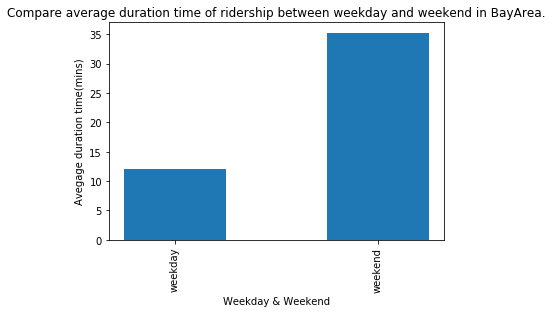

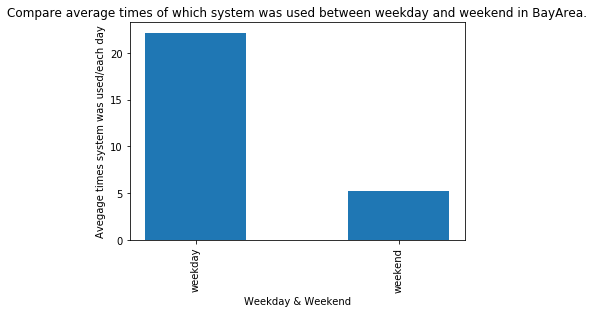

Subscribers are most likely to use the system on Tuesday, whereas Customers on Saturday.


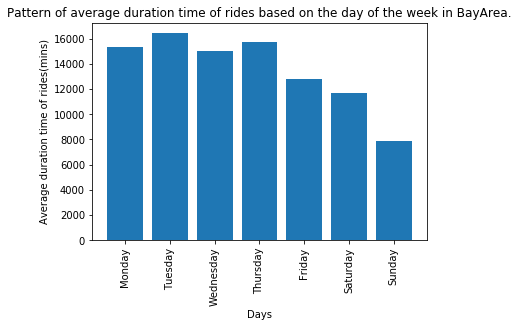

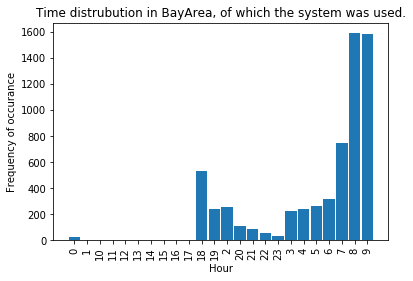

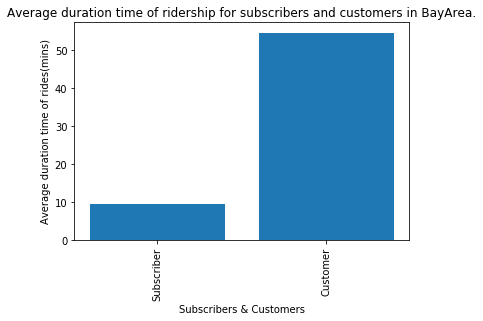

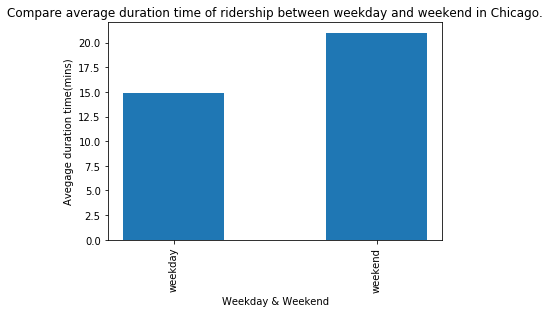

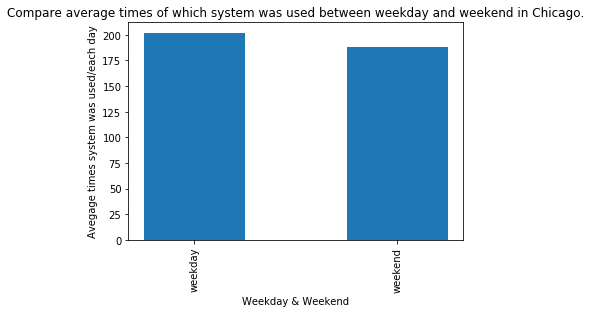

Subscribers are most likely to use the system on Tuesday, whereas Customers on Sunday.


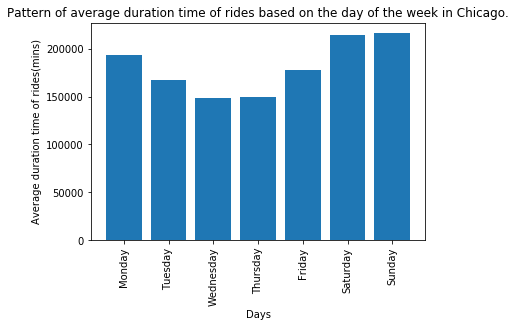

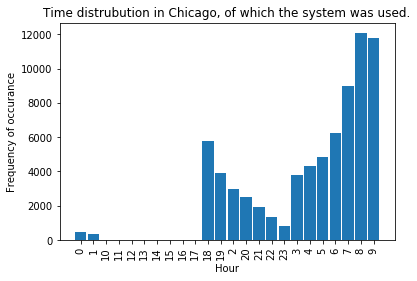

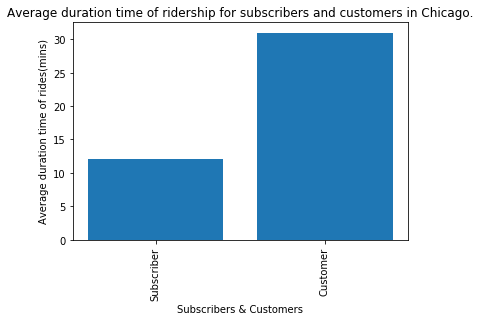

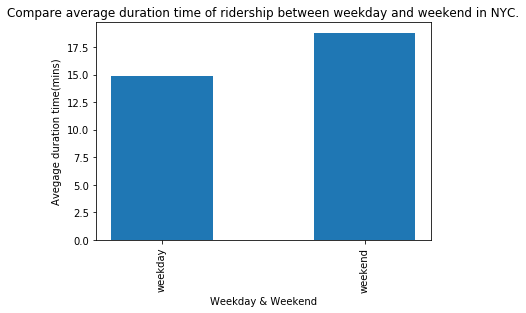

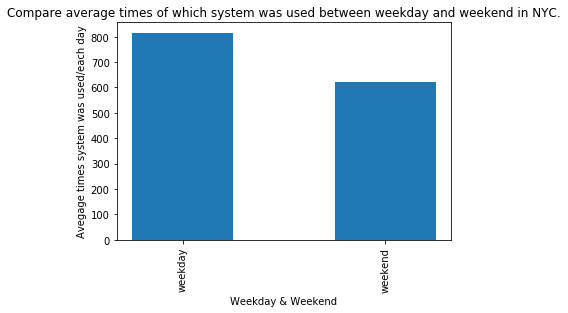

Subscribers are most likely to use the system on Wednesday, whereas Customers on Saturday.


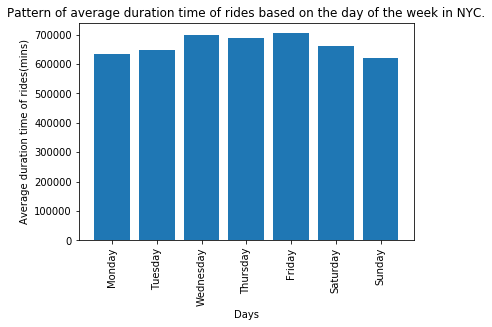

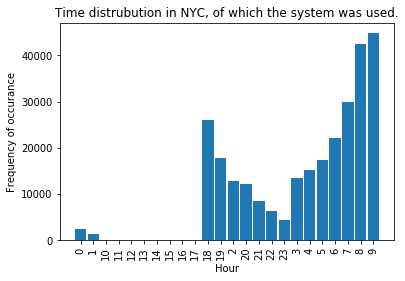

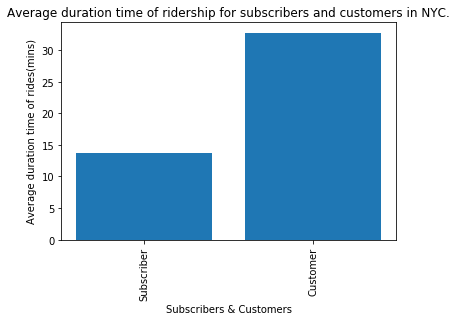

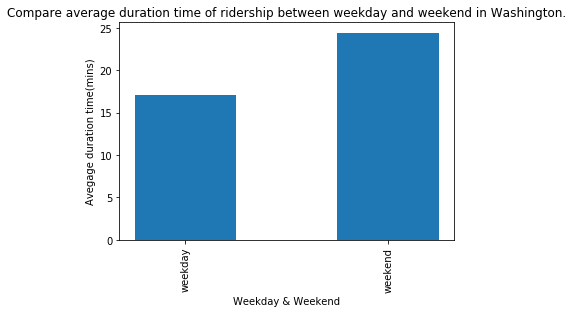

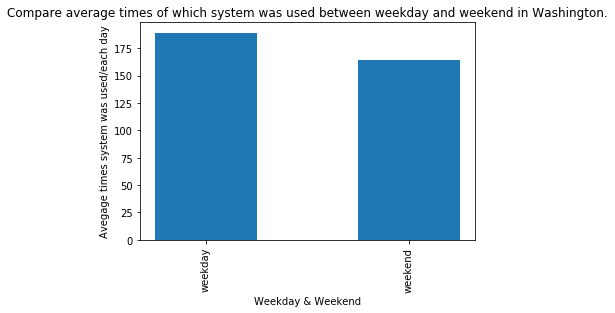

Subscribers are most likely to use the system on Wednesday, whereas Customers on Saturday.


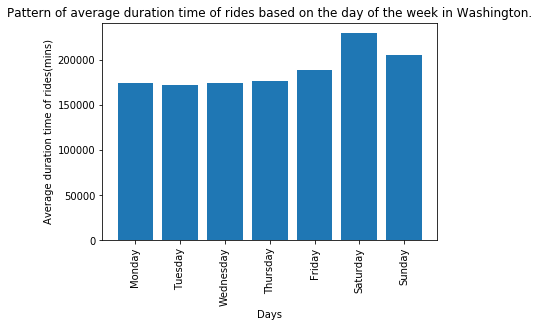

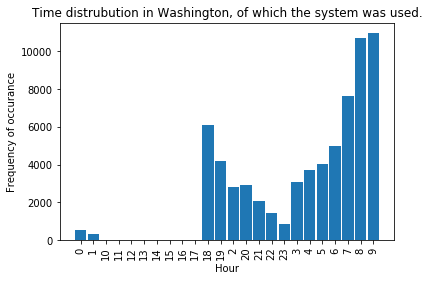

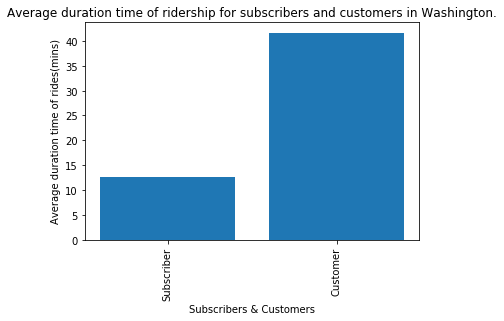

In [16]:
# is the pattern of ridership different on the weekends versus weekdays? 
# on what days are Subscribers most likely to use the system? What about Customers? 
# does the average duration of rides change depending on the day of the week?
# during what time of day is the system used the most? 
# is there a difference in usage patterns for Subscribers and Customers?

def pattern(filename):
    
    tol_times_weekday_weekend={'weekday':0,'weekend':0}
    tot_dur_weekday_weekend={'weekday':0,'weekend':0}
    total_day_weekday_weekend={'weekday':260,'weekend':104} # 1 year has 52 weeks.
    dur_sub_cus={'Subscriber':0,'Customer':0}
    times_sub_cub={'Subscriber':0,'Customer':0}
    sub_use_day=[]
    cus_use_day=[]
    dur_all={'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    times_all={'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    timelist=[]
    
    {'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0,'Saturday':0,'Sunday':0}
    
    with open (filename,'r') as f_in:
        reader=csv.DictReader(f_in)
        
        for row in reader:
            
            if row['day_of_week']=='Saturday' or row['day_of_week']=='Sunday':
                tol_times_weekday_weekend['weekend']+=1
                tot_dur_weekday_weekend['weekend']+=float(row['duration'])
            else:
                tol_times_weekday_weekend['weekday']+=1
                tot_dur_weekday_weekend['weekday']+=float(row['duration'])
            
            if row['user_type']=='Subscriber':
                dur_sub_cus['Subscriber'] += float(row['duration'])
                times_sub_cub['Subscriber']+=1
                sub_use_day.append(row['day_of_week'])
            else:
                dur_sub_cus['Customer'] += float(row['duration'])
                times_sub_cub['Customer']+=1
                cus_use_day.append(row['day_of_week'])
                
            dur_all[row['day_of_week']]+=float(row['duration']) 
            times_all[row['day_of_week']]+=1
            timelist.append(row['hour'])
                            
    avg_dur_weekday_weekend=dict((k, float(tot_dur_weekday_weekend[k])/tol_times_weekday_weekend[k]) \
                                 for k in tot_dur_weekday_weekend)
    avg_times_weekday_weekend=dict((k, float(tol_times_weekday_weekend[k])/total_day_weekday_weekend[k]) \
                                   for k in tol_times_weekday_weekend)          
                      
    sub_most_day=mode(sub_use_day)  
    cus_most_day=mode(cus_use_day)
    
    avg_dur_weekly=dict((k, float(dur_all[k]) + times_all[k]) for k in dur_all)
    
    avg_dur_sub_cus=dict((k, float(dur_sub_cus[k])/times_sub_cub[k]) for k in dur_sub_cus)
        
    return avg_dur_weekday_weekend,avg_times_weekday_weekend,sub_most_day,cus_most_day,\
           avg_dur_weekly,timelist,avg_dur_sub_cus
                                                                                                    
for file in data_file:
    city=file.split('-')[0].split('/')[-1]
    a,b,c,d,e,f,g=pattern(file)
    
    plt.bar(range(len(a)), a.values(), align='center',width=0.5)
    plt.xticks(range(len(a)), a.keys())
    plt.xticks(rotation='vertical')
    plt.title('Compare average duration time of ridership between weekday and weekend in {}.'.format(city))
    plt.xlabel('Weekday & Weekend')
    plt.ylabel('Avegage duration time(mins)')
    plt.show()
    
    plt.bar(range(len(b)), b.values(), align='center',width=0.5)
    plt.xticks(range(len(b)), b.keys())
    plt.xticks(rotation='vertical')
    plt.title('Compare average times of which system was used between weekday and weekend in {}.'.format(city))
    plt.xlabel('Weekday & Weekend')
    plt.ylabel('Avegage times system was used/each day')
    plt.show()
    
    print('Subscribers are most likely to use the system on {}, whereas Customers on {}.'.format(c,d))
    
    plt.bar(range(len(e)), e.values(), align='center',width=0.8)
    plt.xticks(range(len(e)), e.keys())
    plt.xticks(rotation='vertical')
    plt.title('Pattern of average duration time of rides based on the day of the week in {}.'.format(city))
    plt.xlabel('Days')
    plt.ylabel('Average duration time of rides(mins)')
    plt.show()
    
    plt.hist(f,bins=24,range=(0,24),rwidth=0.9,align='left')
    plt.xticks(rotation='vertical')
    plt.title('Time distrubution in {}, of which the system was used.'.format(city))
    plt.xlabel('Hour')
    plt.ylabel('Frequency of occurance')
    plt.show()
                            
    plt.bar(range(len(g)), g.values(), align='center',width=0.8)
    plt.xticks(range(len(g)), g.keys())
    plt.xticks(rotation='vertical')
    plt.title('Average duration time of ridership for subscribers and customers in {}.'.format(city))
    plt.xlabel('Subscribers & Customers')
    plt.ylabel('Average duration time of rides(mins)')
    plt.show()
    

<a id='conclusions'></a>
## Conclusions

We have done quite a lot of profound analysis based on such a limited set of data, however, there are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data have not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, the weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?

We can also apply this technique to medical information processing or drug development field, such as management of health data and medical records, estimating the effects of one drug over another or placebo as well as evaluating its toxicity. More important, nowadays computer based drug design is developing rapidly, that machine learning based on substantial clinical data plays an increasing important role in the design of new drug.


In [21]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Explore_US_Bikeshare_Data_20171207.ipynb'])

0